# Load results

In [8]:
from notebooks.results import load_run_result, find_run_paths, RunResult
from notebooks.analysis import erase_labels

root = "/mnt/ssd-1/alexm/weak-to-strong/results/logconf/amazon_polarity"

paths = find_run_paths(root)

r_all = load_run_result(**paths)
print(f"Weak floor: {r_all.weak_acc:.2f}")
print(f"Strong ceiling: {r_all.strong_acc:.2f}")
print(f"W2S: {r_all.w2s_acc:.2f} (PGR: {r_all.pgr:.2f})")

Weak floor: 0.61
Strong ceiling: 0.96
W2S: 0.64 (PGR: 0.10)


In [9]:
# select a range of training steps to keep data from
r = r_all.select(0, r_all.run.n_steps)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import numpy as np

def project_onto(x, y=None, method="lr", pca=None, coef=None, **args):
    if method == "lr":
        assert y is not None
        assert ((y == 0) | (y == 1)).all()
        lr = LogisticRegression(**args)
        lr.fit(x, y)
        lr.coef_ /= np.linalg.norm(lr.coef_)
        return x @ lr.coef_.flatten()
    elif method == "mean-diff":
        assert y is not None
        assert ((y == 0) | (y == 1)).all()
        classifier = x[y == 1].mean(axis=0) - x[y == 0].mean(axis=0)
        classifier /= np.linalg.norm(classifier)
        return x @ classifier
    elif method.startswith("pca"):
        idx = int(method[len("pca"):]) - 1
        if pca is None:
            pca = PCA(n_components=100)
            pca.fit(x)
        return pca.transform(x)[:, idx]
    elif method == "provided":
        assert coef is not None
        return x @ coef
    else:
        raise ValueError(f"Unknown method {method}")
    
def get_labs(r: RunResult, name):
    if name == "is_correct":
        return r.w2s_train.gt_hard_labels == (r.w2s_train.weak_soft_labels > 0.5)
    elif name == "is_fp":
        return (r.w2s_train.gt_hard_labels == 0) & (r.w2s_train.weak_soft_labels > 0.5)
    elif name == "is_fn":
        return (r.w2s_train.gt_hard_labels == 1) & (r.w2s_train.weak_soft_labels < 0.5)
    elif name == "is_tp":
        return (r.w2s_train.gt_hard_labels == 1) & (r.w2s_train.weak_soft_labels > 0.5)
    elif name == "is_tn":
        return (r.w2s_train.gt_hard_labels == 0) & (r.w2s_train.weak_soft_labels < 0.5)
    elif name == "weak_hard_labels":
        return r.w2s_train.weak_soft_labels > 0.5
    else:
        return getattr(r.w2s_train, name)


PCA Explained variance: 0.7178968787193298


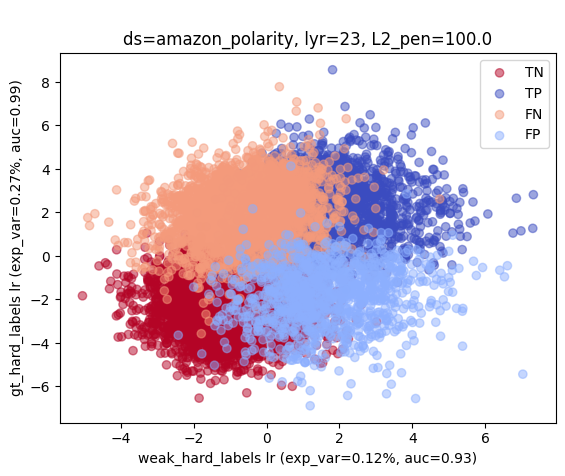

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

layer = 23
h = r.w2s_train.pre_hiddens[:, layer, :]  # type: ignore
# h, mask = erase_labels(h, r.run.weak_soft_labels, label_erasure="leace")
h = h - h.mean(axis=0)
pca = PCA(n_components=100)
pca.fit(h)

l2 = 1e2
args = {"C": 1 / l2, "max_iter": 1000}
x_axis_method, x_axis = "lr", "weak_hard_labels"
y_axis_method, y_axis = "lr", "gt_hard_labels"
x_axis_labs = get_labs(r, x_axis)
y_axis_labs = get_labs(r, y_axis)
proj0 = project_onto(h, x_axis_labs, method=x_axis_method, pca=pca, **args)
proj1 = project_onto(h, y_axis_labs, method=y_axis_method, pca=pca, **args)
h_proj = np.stack([proj0, proj1], axis=1)

ova_var = np.square(h).sum()
exp_var1 = np.square(h_proj[:, 0]).sum() / ova_var
exp_var2 = np.square(h_proj[:, 1]).sum() / ova_var
auc1 = roc_auc_score(x_axis_labs > 0.5, h_proj[:, 0])
auc2 = roc_auc_score(y_axis_labs > 0.5, h_proj[:, 1])
print(f"PCA Explained variance: {pca.explained_variance_ratio_.sum()}")
c = np.empty(r.w2s_train.n, dtype=float)
c[get_labs(r, "is_tn")] = 0  # True negative
c[get_labs(r, "is_tp")] = 1  # True positive
c[get_labs(r, "is_fn")] = 0.25  # False negative
c[get_labs(r, "is_fp")] = 0.75  # False positive
for color, name in zip([0, 1, 0.25, 0.75], ["TN", "TP", "FN", "FP"]):
    m = c == color
    plt.scatter(h_proj[:, 0][m], h_proj[:, 1][m], c=c[m], cmap="coolwarm_r", alpha=0.5, vmin=0, vmax=1, label=name)

plt.xlabel(f"{x_axis} {x_axis_method} (exp_var={100*exp_var1:.2f}%, auc={auc1:.2f})")
plt.ylabel(f"{y_axis} {y_axis_method} (exp_var={100*exp_var2:.2f}%, auc={auc2:.2f})")

ds_name = r.cfg["ds_name"]
plt.title(f"\nds={ds_name}, lyr={layer}, L2_pen={l2}")

plt.legend()
plt.show()


# HDBSCAN

In [19]:
from hdbscan import HDBSCAN

pca_h = pca.transform(h)[:, :20]
pca_h, _ = erase_labels(pca_h, r.run.weak_soft_labels, label_erasure="leace")

clusterer = HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)
clusterer.fit(pca_h)

HDBSCAN()

<Axes: ylabel='$\\lambda$ value'>

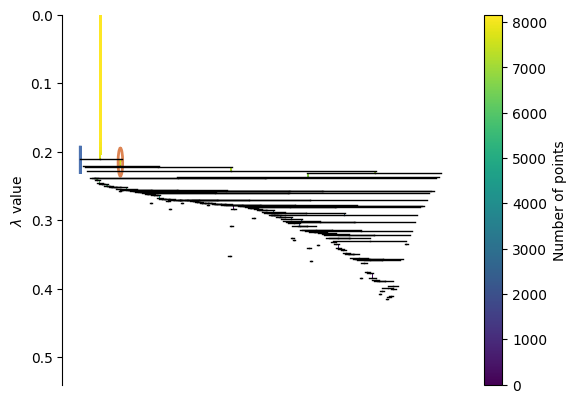

In [122]:
import seaborn as sns
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep', 8))

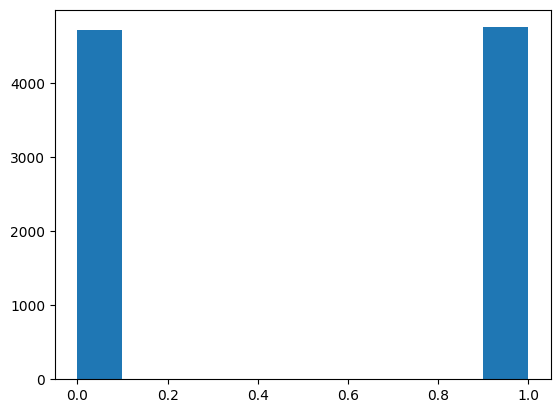

In [25]:
# distance = 1/lambd
clusters = clusterer.single_linkage_tree_.get_clusters(1/0.21, min_cluster_size=100)
plt.hist(r.w2s_train.gt_soft_labels[clusters == -1], density=False)
plt.show()

# Kernel grads

In [23]:
# f(x; theta, b) = x @ theta
# grad |f - y| = sign(y - f) * x
# grad f = x
# kernel grad = x_test @ sign(y - f) * x_trainn_test = 1000
n_test = 1000
test_idxs = np.random.choice(r.run.n, n_test, replace=False)
layer = 20
h = r.run.midtrain_hiddens[:, layer, :]
test_h = h[test_idxs]

train_grads = (2 * r.run.weak_soft_labels[:, None] - 1) * h
kernel_grads = train_grads @ test_h.T

# do batch averaging or something to eliminate unwanted variance
batch_size, n_batches = 32, 1000
batches = np.random.choice(len(h), n_batches * batch_size, replace=True)

train_grads = (2 * r.run.weak_soft_labels[:, None] - 1) * h
batch_grads = train_grads[batches].reshape(n_batches, batch_size, -1).mean(axis=1)
batch_kernel_grads = batch_grads @ test_h.T

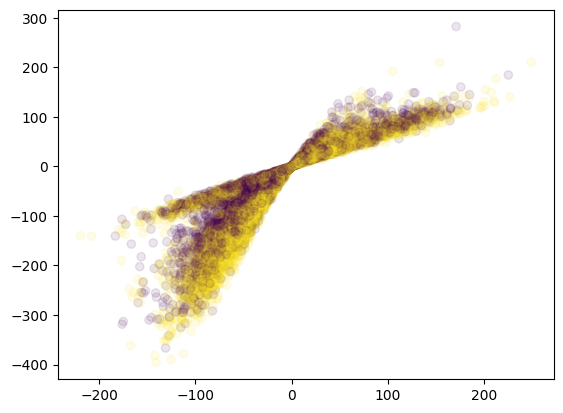

In [24]:
plt.scatter(kernel_grads[:, 0], kernel_grads[:, 1], alpha=0.1, c=get_labs(r, "is_correct"))